# EDA

In [1]:
import pandas as pd
import numpy as np

import missingno as msno
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split 
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import datetime
from dateutil.parser import parse
from sklearn.tree import  DecisionTreeClassifier
import plotly.graph_objects as go
import umap
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
import ml_metrics
import seaborn as sns
import warnings
from plotly.subplots import make_subplots
from sklearn.metrics import accuracy_score
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore")



In [2]:
Data=pd.read_csv("../Datos/cleaned_05June2022.csv").drop(columns=["Unnamed: 0"]).fillna("")
Data.head()

Duracion_Campaña    B    C  lec_B-B  lec_E-E  lec_D-E  lec_C-D  lec_A-A  \
0               1.0  4.0  5.0      5.0      0.0      0.0      0.0      0.0   
1               1.0  6.0  6.0      8.0      0.0      1.0      1.0      0.0   
2               1.0  2.0  3.0      1.0      0.0      0.0      1.0      0.0   
3               1.2  7.0  3.0      5.0      0.0      0.0      2.0      2.0   
4               1.0  4.0  1.0      1.0      0.0      0.0      0.0      0.0   

   num_comunicaciones  Length  ...  Renta  Recibe_sueldo_en_cuenta  \
0                22.0     371  ...     R1                        0   
1                15.0     371  ...     R4                        0   
2                26.0     371  ...     R5                        0   
3                34.0     371  ...     R9                        0   
4                24.0     371  ...     R2                        0   

   Segmento_consumidor  Meses_antiguedad  Comuna  Ciudad  Estado_civil  \
0                    A   Mayor a 10 años   331.0    13.0             D   
1                    A   Mayor a 10 años    91.0    13.0             D   
2                    A   Mayor a 10 años    34.0     5.0             B   
3                    A   Mayor a 10 años   331.0    13.0             B   
4                    B   Mayor a 10 años    37.0     5.0             D   

   Principalidad  Profesion       Target  
0              B       P164               
1              B        P85  E-E B-B D-E  
2              C       P143      D-E A-A  
3              C         P1          E-E  
4              F       P210          D-E  

[5 rows x 40 columns]

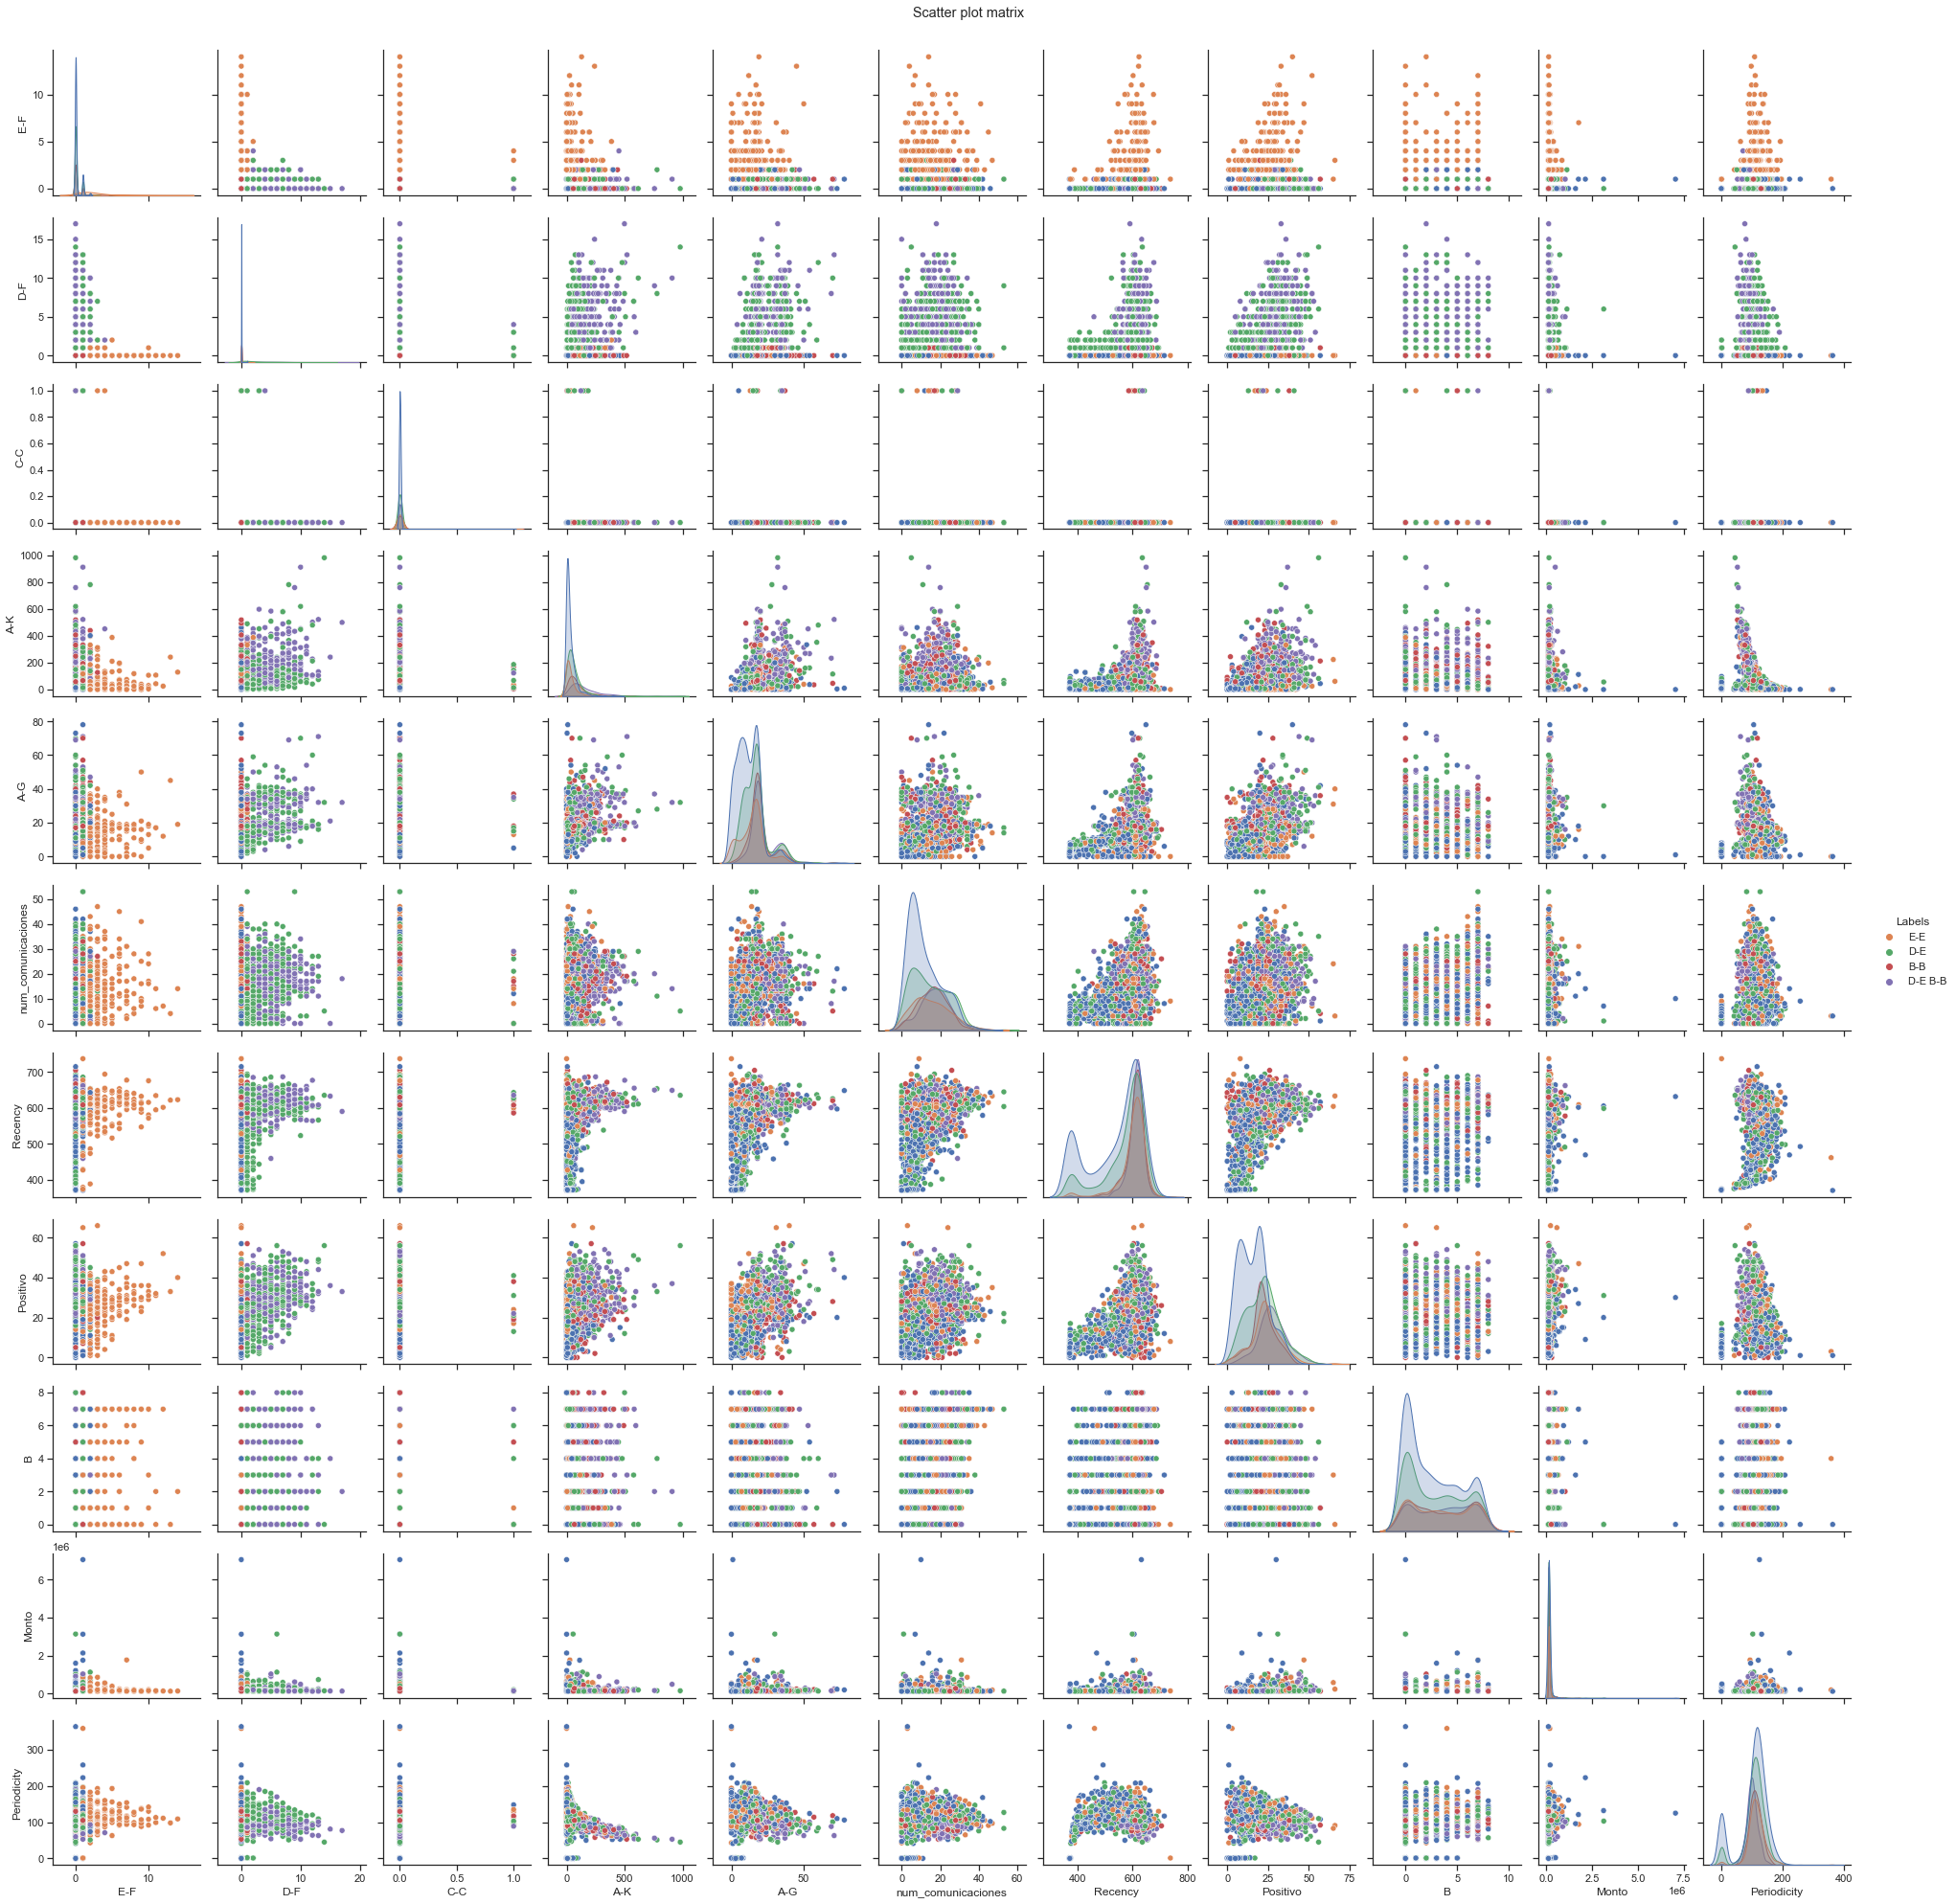

In [78]:
# Visualización de productos más comprados
targets_creibles=list(Data["Target"].value_counts()[Data["Target"].value_counts()>4000].index)
muestra=Data[Data["Target"].isin(targets_creibles)].sample(3000)[['E-F',
 'D-F',
 'C-C',
 'A-K',
 'A-G',
 'num_comunicaciones',
 'Recency',
 'Positivo',
 'B',
 'Monto',
 'Periodicity',"Target"]]
 
matrix=muestra

matrix["Labels"]=muestra["Target"]


sns.set(style="ticks", color_codes=True)
g=sns.pairplot(matrix,diag_kind="kde",hue="Labels")
g.fig.suptitle("Scatter plot matrix",position=(0.5, 1.01))

plt.show()

**Distribucion Target**

In [3]:
# Visualización
px.histogram(Data, x="Target",title="Distribution Plot Target")

In [12]:
X=Data.drop(columns=["Target"]).copy()


In [13]:
Y=Data["Target"]


In [14]:
# Sobremuestreo: Aumentar numero de datos de la clase minoritaria
# ROS(Duplica clases):
rus=RandomUnderSampler(random_state=0) # Random_state=0

In [15]:
# ROS:
X,Y=rus.fit_resample(X,Y)

In [16]:
# datos númericos
numerical=list(X.select_dtypes(exclude=["category","object"]).columns)
numerical.remove("Sexo")
numerical.remove('Recibe_sueldo_en_cuenta')


# datos categorical
categorical=list(X.select_dtypes(include=["category","object"]).columns)+['Sexo','Recibe_sueldo_en_cuenta']
categorical

['Edad',
 'Renta',
 'Segmento_consumidor',
 'Meses_antiguedad',
 'Comuna',
 'Ciudad',
 'Estado_civil',
 'Principalidad',
 'Profesion',
 'Sexo',
 'Recibe_sueldo_en_cuenta']

In [55]:
for i in categorical:
    X[i]=X[i].astype(str)

# Visualización de baja dimensionalidad

In [19]:
# Pipeline provisorio para pre-procesar los datos y luego realizar reducción de dimensionalidad

# Columns transformer
preprocessing_transformer = ColumnTransformer(
    transformers=[
        ('OneHotEncoder', OneHotEncoder(handle_unknown="ignore"),  
          categorical),
        ('StandardScaler', MinMaxScaler(),
         numerical),
    ])

#Pipelines

pipe_process_2d_umap = Pipeline(
    [("preprocesamiento", preprocessing_transformer),("reducción de dimensionalidad",
                                                      umap.UMAP(n_components=2, random_state=42))]
)

pipe_process_3d_umap = Pipeline(
    [("preprocesamiento", preprocessing_transformer),("reducción de dimensionalidad",
                                                      umap.UMAP(n_components=3, random_state=42))]
)

In [34]:
# Dataframes de baja dimensionalidad

data_process_2d_umap=pd.DataFrame(pipe_process_2d_umap.fit_transform(X),columns=['x_umap','y_umap'])
data_process_3d_umap=pd.DataFrame(pipe_process_3d_umap.fit_transform(X),columns=['x_umap','y_umap','z_umap'])

In [35]:
Y.replace("","Nada",inplace=True)

In [36]:
data_process_2d_umap["Target"]=Y
data_process_3d_umap["Target"]=Y

In [37]:
# 2d
px.scatter(data_process_2d_umap, x='x_umap', y='y_umap',color="Target", title='2d UMAP')

In [38]:
# 3d
fig = px.scatter_3d(
    data_process_3d_umap,
    x='x_umap',
    y='y_umap',
    z='z_umap',
    color="Target",
    title='3d UMAP'
)
fig.show()

# Clusters

In [28]:
# Iteración de inercias sobre cada número de clusters ejecutado
inertias = [
    [i, Pipeline([('Preprocessing', preprocessing_transformer),('k-means', KMeans(n_clusters=i, random_state=0))]).fit(X)[1].inertia_]
    for i in range(1, 21)]

# Se guardan inercias y número de clusters en un data frame
inertias = pd.DataFrame(inertias, columns=["n° clusters", "inertia"])

In [29]:
# Visualización del método del codo
px.line(inertias, x="n° clusters", y="inertia", title="Método del Codo con K-Means")

In [39]:
# Pipeline entrenamiento k-means con 6 clusters
pipeline2=Pipeline([('Preprocessing', preprocessing_transformer),('k-means', KMeans(n_clusters=6, random_state=0))])

In [40]:
# Entrenamiento de pipeline
pipeline2.fit(X)

Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Edad', 'Renta',
                                                   'Segmento_consumidor',
                                                   'Meses_antiguedad', 'Comuna',
                                                   'Ciudad', 'Estado_civil',
                                                   'Principalidad', 'Profesion',
                                                   'Sexo',
                                                   'Recibe_sueldo_en_cuenta']),
                                                 ('StandardScaler',
                                                  MinMaxScaler(),
                                                  ['Duracion_Campaña', 'B', 'C',
                                                   'lec_B-B', 'lec_E-E',
 

In [41]:
# Predicción de labels
labels=pipeline2.predict(X)
labels

array([4, 4, 5, ..., 0, 2, 0])

In [49]:
data_process_2d_umap["Clusters"]=labels
data_process_3d_umap["Clusters"]=labels

In [50]:
# Para la visualización agregamos los labels al dataframe de baja dimensionalidad
data_process_2d_umap["Clusters"]=data_process_2d_umap["Clusters"].astype("category")
data_process_3d_umap["Clusters"]=data_process_3d_umap["Clusters"].astype("category")

In [51]:
# 2s
px.scatter(data_process_2d_umap, x='x_umap', y='y_umap',color="Clusters", title='2d UMAP')

In [52]:
# 3d
fig = px.scatter_3d(
    data_process_3d_umap,
    x='x_umap',
    y='y_umap',
    z='z_umap',
    color="Clusters",
    title='3d UMAP'
)
fig.show()

# Análisis univariado

In [ ]:
# Numeric
for i in numerical:
    sns.displot(X, x=i, kde=True)
    plt.show()

In [ ]:
# Categorical
for i in categorical:
    fig = px.histogram(Data, x=i, marginal="box",title="Distribution Plot "+i,height=800,
                      width=1000)
    fig.show()

# Análisis bivariado

In [23]:
def profile_df(dataframe_in):
    df = dataframe_in.copy()

    list_type = numerical
   

    
    display(Markdown('## Bivariant Analysis:'))
    for i in range(len(list_type)):
        for j in range(i+1, len(list_type)):
            plt.scatter(df[list_type[i]], df[list_type[j]])
            plt.xlabel(list_type[i]) 
            plt.ylabel(list_type[j]) 
            plt.title(f"{list_type[i]} v/s {list_type[j]}")
            plt.show()

    display(Markdown('## Correlation:'))
    fig_corr = px.imshow(df.corr())
    fig_corr.show()

    display(Markdown('## Missing Matrix:'))
    fig, ax = plt.subplots(figsize=[15, 10])
    msno.matrix(df, ax=ax, sparkline=False)

In [ ]:
profile_df(Data)